In [1]:
# packages
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from torchmetrics.detection import IntersectionOverUnion
from PIL import Image
import os
import cv2
import numpy as np
import json
import shutil
from torchsummary import summary
from PIL import Image
import random

In [2]:
#constants
DEBUG = True
BATCH_SIZE = 32#16#32#64#32
NUM_EPOCHS = 10#160#50

if not torch.cuda.is_available():
    print('GPU not available, running script on CPU..')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
#Data base addresses
base_adress = '/kaggle/input/dataset-face-detection-for-edge-computing-class/Dataset_FDDB/Dataset_FDDB/images'
labels_adr = '/kaggle/input/dataset-face-detection-for-edge-computing-class/Dataset_FDDB/Dataset_FDDB/label.txt'

In [4]:
# Make the labels ready
#import os
#print(os.listdir('/kaggle/input/Dataset_FDDB/Dataset_FDDB/label.txt'))
with open(labels_adr, 'r') as f:
    lines = f.readlines()
annotations = []
bboxes = []
flag = False
for line in lines:
    if line.startswith('#'):
      if flag:
        annotations.append({'image':img_name, 'bboxes': bboxes})
        bboxes = []
      flag = True
      img_name = line[2:]
    else:
      x_min, y_min, x_max, y_max = line.split()
      bboxes.append([int(x_min), int(y_min), int(x_max), int(y_max)])

In [5]:
# Custom Dataset Class for FDDB
class FDDBDataset(Dataset):
    def __init__(self, img_dir, annot_file, target_size=(224, 224), _transform=None, augment=False):
        self.img_dir = img_dir
        self.target_size = target_size
        self.augment = augment
        self.data = self._parse_annotations(annot_file)
        self._transform = _transform

    def _parse_annotations(self, annot_file):
        
        data = []
        for el in annot_file:
          img_path = os.path.join(self.img_dir, el['image'][:-1])
          boxes = el['bboxes']
          data.append((img_path, boxes))
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, boxes = self.data[idx]
        image = cv2.imread(img_path)
        if image is None:
            raise FileNotFoundError(f"Image not found: {img_path}")

        # Original dimensions
        h, w, _ = image.shape

        # Resize image
        image_resized = cv2.resize(image, self.target_size)
        target_h, target_w = self.target_size

        # Scale bounding boxes
        scale_x = target_w / w
        scale_y = target_h / h
        boxes_resized = []
        for box in boxes:
            x_min = int(box[0] * scale_x)
            y_min = int(box[1] * scale_y)
            x_max = int(box[2] * scale_x)
            y_max = int(box[3] * scale_y)
            boxes_resized.append([x_min, y_min, x_max, y_max])

        # Convert to tensor
        if self.augment:
            image_resized = self.transform(image_resized)
        else:
            #image_resized = transforms.ToTensor()(image_resized)
            image_resized = self.augment_data(image_resized)
            image_resized = self._transform(image_resized)

        return image_resized, torch.tensor(boxes_resized, dtype=torch.float32)
    
    def augment_data(self, image):
        # data augmentation
        #image_array = np.array(image)
        image_array = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image_array)

        # random scaling up to 20% original image size
        #scale = transforms.RandomAffine(degrees=0, scale=(0.2, 1.2))
        #image = scale(image)
        return image

        # random translations up to 20% original image size
        #translate = transforms.RandomAffine(degrees=0, translate=(0.2, 0.2))
        #image = translate(image)

        # randomly adjust exposure of image by factor of 1.5
        #adjust_exposure = transforms.ColorJitter(0, 1.5)
        #image = adjust_exposure(image)

        # randomly adjust saturation of image by factor of 1.5
        #adjust_saturation = transforms.ColorJitter(0, 1.5)
        #image = adjust_saturation(image)
        
        #to_tensor = transforms.ToTensor()
        #image = to_tensor(image)
        #normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        #image = normalize(image)
        #image = self._transform(image)

        return image

In [6]:
# DataLoader preparation
def get_dataloaders(img_dir, annot_file, batch_size=BATCH_SIZE, target_size=(224, 224), validation_split=0.2):
    _transform = transforms.Compose([
        transforms.RandomAffine(degrees=0, scale=(0.2, 1.2)),
        transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)),
        transforms.ColorJitter(brightness=(0, 1.5), saturation=(0, 1.5)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    # Dataset
    dataset = FDDBDataset(img_dir, annot_file, target_size, _transform, augment=False)

    # Split dataset
    val_size = int(len(dataset) * validation_split)
    train_size = len(dataset) - val_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

    # DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    return train_loader, val_loader

def collate_fn(batch):
    """
    Custom collate function to handle variable-length bounding box arrays.

    :param batch: List of tuples (image, boxes).
    :return: Tuple of images and targets.
    """
    images = torch.stack([item[0] for item in batch])
    targets = [item[1] for item in batch]
    return images, targets

In [7]:
class MyFaceDetector(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        # TODO: resize input images to 448p (or stay 224p?)
        # TODO: threshold the resulting detections by the model's confidence
        # architecture from original YOLO paper
        # architecture improved according to YOLOv2 paper

        # conv layer 1
        self.conv1 = nn.Conv2d(
            in_channels=3,
            out_channels=64,
            kernel_size=7,
            stride=2,
            padding=1
        )
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.LeakyReLU(negative_slope=0.1)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(
            in_channels=64,
            out_channels=192,
            kernel_size=3,
            stride=1,
            padding=1
        )
        self.bn2 = nn.BatchNorm2d(192)
        self.relu2 = nn.LeakyReLU(negative_slope=0.1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(
            in_channels=192,
            out_channels=128,
            kernel_size=1,
            stride=1,
            padding=1
        )
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.LeakyReLU(negative_slope=0.1)
        self.conv4 = nn.Conv2d(
            in_channels=128,
            out_channels=256,
            kernel_size=3,
            stride=1,
            padding=1
        )
        self.bn4 = nn.BatchNorm2d(256)
        self.relu4 = nn.LeakyReLU(negative_slope=0.1)
        self.conv5 = nn.Conv2d(
            in_channels=256,
            out_channels=256,
            kernel_size=1,
            stride=1,
            padding=1
        )
        self.bn5 = nn.BatchNorm2d(256)
        self.relu5 = nn.LeakyReLU(negative_slope=0.1)
        self.conv6 = nn.Conv2d(
            in_channels=256,
            out_channels=512,
            kernel_size=3,
            stride=1,
            padding=1
        )
        self.bn6 = nn.BatchNorm2d(512)
        self.relu6 = nn.LeakyReLU(negative_slope=0.1)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv7 = nn.Conv2d(
            in_channels=512,
            out_channels=256,
            kernel_size=1,
            stride=1,
            padding=1
        )
        self.bn7 = nn.BatchNorm2d(256)
        self.relu7 = nn.LeakyReLU(negative_slope=0.1)
        self.conv8 = nn.Conv2d(
            in_channels=256,
            out_channels=512,
            kernel_size=3,
            stride=1,
            padding=1
        )
        self.bn8 = nn.BatchNorm2d(512)
        self.relu8 = nn.LeakyReLU(negative_slope=0.1)
        self.conv9 = nn.Conv2d(
            in_channels=512,
            out_channels=256,
            kernel_size=1,
            stride=1,
            padding=1
        )
        self.bn9 = nn.BatchNorm2d(256)
        self.relu9 = nn.LeakyReLU(negative_slope=0.1)
        self.conv10 = nn.Conv2d(
            in_channels=256,
            out_channels=512,
            kernel_size=3,
            stride=1,
            padding=1
        )
        self.bn10 = nn.BatchNorm2d(512)
        self.relu10 = nn.LeakyReLU(negative_slope=0.1)
        self.conv11 = nn.Conv2d(
            in_channels=512,
            out_channels=256,
            kernel_size=1,
            stride=1,
            padding=1
        )
        self.bn11 = nn.BatchNorm2d(256)
        self.relu11 = nn.LeakyReLU(negative_slope=0.1)
        self.conv12 = nn.Conv2d(
            in_channels=256,
            out_channels=512,
            kernel_size=3,
            stride=1,
            padding=1
        )
        self.bn12 = nn.BatchNorm2d(512)
        self.relu12 = nn.LeakyReLU(negative_slope=0.1)
        self.conv13 = nn.Conv2d(
            in_channels=512,
            out_channels=256,
            kernel_size=1,
            stride=1,
            padding=1
        )
        self.bn13 = nn.BatchNorm2d(256)
        self.relu13 = nn.LeakyReLU(negative_slope=0.1)
        self.conv14 = nn.Conv2d(
            in_channels=256,
            out_channels=512,
            kernel_size=3,
            stride=1,
            padding=1
        )
        self.bn14 = nn.BatchNorm2d(512)
        self.relu14 = nn.LeakyReLU(negative_slope=0.1)
        self.conv15 = nn.Conv2d(
            in_channels=512,
            out_channels=512,
            kernel_size=1,
            stride=1,
            padding=1
        )
        self.bn15 = nn.BatchNorm2d(512)
        self.relu15 = nn.LeakyReLU(negative_slope=0.1)
        self.conv16 = nn.Conv2d(
            in_channels=512,
            out_channels=1024,
            kernel_size=3,
            stride=1,
            padding=1
        )
        self.bn16 = nn.BatchNorm2d(1024)
        self.relu16 = nn.LeakyReLU(negative_slope=0.1)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv17 = nn.Conv2d(
            in_channels=1024,
            out_channels=512,
            kernel_size=1,
            stride=1,
            padding=1
        )
        self.bn17 = nn.BatchNorm2d(512)
        self.relu17 = nn.LeakyReLU(negative_slope=0.1)
        self.conv18 = nn.Conv2d(
            in_channels=512,
            out_channels=1024,
            kernel_size=3,
            stride=1,
            padding=1
        )
        self.bn18 = nn.BatchNorm2d(1024)
        self.relu18 = nn.LeakyReLU(negative_slope=0.1)
        # TODO: is the order of multipliers from the architecture correct?
        self.conv19 = nn.Conv2d(
            in_channels=1024,
            out_channels=512,
            kernel_size=1,
            stride=1,
            padding=1
        )
        self.bn19 = nn.BatchNorm2d(512)
        self.relu19 = nn.LeakyReLU(negative_slope=0.1)
        self.conv20 = nn.Conv2d(
            in_channels=512,
            out_channels=1024,
            kernel_size=3,
            stride=1,
            padding=1
        )
        self.bn20 = nn.BatchNorm2d(1024)
        self.relu20 = nn.LeakyReLU(negative_slope=0.1)
        self.conv21 = nn.Conv2d(
            in_channels=1024,
            out_channels=1024,
            kernel_size=3,
            stride=1,
            padding=1
        )
        self.bn21 = nn.BatchNorm2d(1024)
        self.relu21 = nn.LeakyReLU(negative_slope=0.1)
        self.conv22 = nn.Conv2d(
            in_channels=1024,
            out_channels=1024,
            kernel_size=3,
            stride=2,
            padding=1
        )
        self.bn22 = nn.BatchNorm2d(1024)
        self.relu22 = nn.LeakyReLU(negative_slope=0.1)
        self.conv23 = nn.Conv2d(
            in_channels=1024,
            out_channels=1024,
            kernel_size=3,
            stride=1,
            padding=1
        )
        self.bn23 = nn.BatchNorm2d(1024)
        self.relu23 = nn.LeakyReLU(negative_slope=0.1)
        self.conv24 = nn.Conv2d(
            in_channels=1024,
            out_channels=1024,
            kernel_size=3,
            stride=1,
            padding=1
        )
        self.bn24 = nn.BatchNorm2d(1024)
        self.relu24 = nn.LeakyReLU(negative_slope=0.1)

        self.flatten = nn.Flatten()

        # regression head
        self.bbox = nn.Sequential(
            nn.Linear(1024*8*8, 4096),
            nn.LeakyReLU(negative_slope=0.1),
            #nn.Dropout(p=0.5),
            nn.Linear(4096, 4)
        )
        
        # classification head
        self.classify = nn.Sequential(
            nn.Linear(1024*8*8, 4096),
            nn.LeakyReLU(negative_slope=0.1),
            #nn.Dropout(p=0.5),
            nn.Linear(4096, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # pass through feature extractor backbone
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.conv5(x)
        x = self.bn5(x)
        x = self.relu5(x)
        x = self.conv6(x)
        x = self.bn6(x)
        x = self.relu6(x)
        x = self.maxpool3(x)
        x = self.conv7(x)
        x = self.bn7(x)
        x = self.relu7(x)
        x = self.conv8(x)
        x = self.bn8(x)
        x = self.relu8(x)
        x = self.conv9(x)
        x = self.bn9(x)
        x = self.relu9(x)
        x = self.conv10(x)
        x = self.bn10(x)
        x = self.relu10(x)
        x = self.conv11(x)
        x = self.bn11(x)
        x = self.relu11(x)
        x = self.conv12(x)
        x = self.bn12(x)
        x = self.relu12(x)
        x = self.conv13(x)
        x = self.bn13(x)
        x = self.relu13(x)
        x = self.conv14(x)
        x = self.bn14(x)
        x = self.relu14(x)
        x = self.conv15(x)
        x = self.bn15(x)
        x = self.relu15(x)
        x = self.conv16(x)
        x = self.bn16(x)
        x = self.relu16(x)
        x = self.maxpool4(x)
        x = self.conv17(x)
        x = self.bn17(x)
        x = self.relu17(x)
        x = self.conv18(x)
        x = self.bn18(x)
        x = self.relu18(x)
        x = self.conv19(x)
        x = self.bn19(x)
        x = self.relu19(x)
        x = self.conv20(x)
        x = self.bn20(x)
        x = self.relu20(x)
        x = self.conv21(x)
        x = self.bn21(x)
        x = self.relu21(x)
        x = self.conv22(x)
        x = self.bn22(x)
        x = self.relu22(x)
        x = self.conv23(x)
        x = self.bn23(x)
        x = self.relu23(x)
        x = self.conv24(x)
        x = self.bn24(x)
        x = self.relu24(x)

        #_, c, h, w = x.shape
        #print(c, h, w)
        
        x = self.flatten(x)
        
        bbox = self.bbox(x)
        label = self.classify(x)

        return bbox, label
model = MyFaceDetector().to(device)
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 110, 110]           9,472
       BatchNorm2d-2         [-1, 64, 110, 110]             128
         LeakyReLU-3         [-1, 64, 110, 110]               0
         MaxPool2d-4           [-1, 64, 55, 55]               0
            Conv2d-5          [-1, 192, 55, 55]         110,784
       BatchNorm2d-6          [-1, 192, 55, 55]             384
         LeakyReLU-7          [-1, 192, 55, 55]               0
         MaxPool2d-8          [-1, 192, 27, 27]               0
            Conv2d-9          [-1, 128, 29, 29]          24,704
      BatchNorm2d-10          [-1, 128, 29, 29]             256
        LeakyReLU-11          [-1, 128, 29, 29]               0
           Conv2d-12          [-1, 256, 29, 29]         295,168
      BatchNorm2d-13          [-1, 256, 29, 29]             512
        LeakyReLU-14          [-1, 256,

In [8]:
class LightFaceDetector(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()

        # conv layer 1
        self.conv1 = nn.Conv2d(
            in_channels=3,
            out_channels=64/8,
            kernel_size=7,
            stride=2,
            padding=1
        )
        self.bn1 = nn.BatchNorm2d(64/8)
        self.relu1 = nn.LeakyReLU(negative_slope=0.1)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(
            in_channels=64/8,
            out_channels=192/8,
            kernel_size=3,
            stride=1,
            padding=1
        )
        self.bn2 = nn.BatchNorm2d(192/8)
        self.relu2 = nn.LeakyReLU(negative_slope=0.1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(
            in_channels=192/8,
            out_channels=128/8,
            kernel_size=1,
            stride=1,
            padding=1
        )
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.LeakyReLU(negative_slope=0.1)
        self.conv4 = nn.Conv2d(
            in_channels=128/8,
            out_channels=256/8,
            kernel_size=3,
            stride=1,
            padding=1
        )
        self.bn4 = nn.BatchNorm2d(256/8)
        self.relu4 = nn.LeakyReLU(negative_slope=0.1)
        self.conv5 = nn.Conv2d(
            in_channels=256/8,
            out_channels=256/8,
            kernel_size=1,
            stride=1,
            padding=1
        )
        self.bn5 = nn.BatchNorm2d(256/8)
        self.relu5 = nn.LeakyReLU(negative_slope=0.1)
        self.conv6 = nn.Conv2d(
            in_channels=256,
            out_channels=512,
            kernel_size=3,
            stride=1,
            padding=1
        )
        self.bn6 = nn.BatchNorm2d(512)
        self.relu6 = nn.LeakyReLU(negative_slope=0.1)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv7 = nn.Conv2d(
            in_channels=256/8,
            out_channels=256/8,
            kernel_size=1,
            stride=1,
            padding=1
        )
        self.bn7 = nn.BatchNorm2d(256/8)
        self.relu7 = nn.LeakyReLU(negative_slope=0.1)
        self.conv8 = nn.Conv2d(
            in_channels=256/8,
            out_channels=512/8,
            kernel_size=3,
            stride=1,
            padding=1
        )
        self.bn8 = nn.BatchNorm2d(512/8)
        self.relu8 = nn.LeakyReLU(negative_slope=0.1)
        self.conv9 = nn.Conv2d(
            in_channels=512/8,
            out_channels=256/8,
            kernel_size=1,
            stride=1,
            padding=1
        )
        self.bn9 = nn.BatchNorm2d(256/8)
        self.relu9 = nn.LeakyReLU(negative_slope=0.1)
        self.conv10 = nn.Conv2d(
            in_channels=256/8,
            out_channels=512/8,
            kernel_size=3,
            stride=1,
            padding=1
        )
        self.bn10 = nn.BatchNorm2d(512/8)
        self.relu10 = nn.LeakyReLU(negative_slope=0.1)
        self.conv11 = nn.Conv2d(
            in_channels=512/8,
            out_channels=256/8,
            kernel_size=1,
            stride=1,
            padding=1
        )
        self.bn11 = nn.BatchNorm2d(256/8)
        self.relu11 = nn.LeakyReLU(negative_slope=0.1)
        self.conv12 = nn.Conv2d(
            in_channels=256/8,
            out_channels=512/8,
            kernel_size=3,
            stride=1,
            padding=1
        )
        self.bn12 = nn.BatchNorm2d(512/8)
        self.relu12 = nn.LeakyReLU(negative_slope=0.1)
        self.conv13 = nn.Conv2d(
            in_channels=512/8,
            out_channels=256/8,
            kernel_size=1,
            stride=1,
            padding=1
        )
        self.bn13 = nn.BatchNorm2d(256/8)
        self.relu13 = nn.LeakyReLU(negative_slope=0.1)
        self.conv14 = nn.Conv2d(
            in_channels=256/8,
            out_channels=512/8,
            kernel_size=3,
            stride=1,
            padding=1
        )
        self.bn14 = nn.BatchNorm2d(512/8)
        self.relu14 = nn.LeakyReLU(negative_slope=0.1)
        self.conv15 = nn.Conv2d(
            in_channels=512/8,
            out_channels=512/8,
            kernel_size=1,
            stride=1,
            padding=1
        )
        self.bn15 = nn.BatchNorm2d(512/8)
        self.relu15 = nn.LeakyReLU(negative_slope=0.1)
        self.conv16 = nn.Conv2d(
            in_channels=512/8,
            out_channels=1024/8,
            kernel_size=3,
            stride=1,
            padding=1
        )
        self.bn16 = nn.BatchNorm2d(1024/8)
        self.relu16 = nn.LeakyReLU(negative_slope=0.1)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv17 = nn.Conv2d(
            in_channels=1024/8,
            out_channels=512/8,
            kernel_size=1,
            stride=1,
            padding=1
        )
        self.bn17 = nn.BatchNorm2d(512/8)
        self.relu17 = nn.LeakyReLU(negative_slope=0.1)
        self.conv18 = nn.Conv2d(
            in_channels=512/8,
            out_channels=1024/8,
            kernel_size=3,
            stride=1,
            padding=1
        )
        self.bn18 = nn.BatchNorm2d(1024/8)
        self.relu18 = nn.LeakyReLU(negative_slope=0.1)
        # TODO: is the order of multipliers from the architecture correct?
        self.conv19 = nn.Conv2d(
            in_channels=1024/8,
            out_channels=512/8,
            kernel_size=1,
            stride=1,
            padding=1
        )
        self.bn19 = nn.BatchNorm2d(512/8)
        self.relu19 = nn.LeakyReLU(negative_slope=0.1)
        self.conv20 = nn.Conv2d(
            in_channels=512/8,
            out_channels=1024/8,
            kernel_size=3,
            stride=1,
            padding=1
        )
        self.bn20 = nn.BatchNorm2d(1024/8)
        self.relu20 = nn.LeakyReLU(negative_slope=0.1)
        self.conv21 = nn.Conv2d(
            in_channels=1024/8,
            out_channels=1024/8,
            kernel_size=3,
            stride=1,
            padding=1
        )
        self.bn21 = nn.BatchNorm2d(1024/8)
        self.relu21 = nn.LeakyReLU(negative_slope=0.1)
        self.conv22 = nn.Conv2d(
            in_channels=1024/8,
            out_channels=1024/8,
            kernel_size=3,
            stride=2,
            padding=1
        )
        self.bn22 = nn.BatchNorm2d(1024/8)
        self.relu22 = nn.LeakyReLU(negative_slope=0.1)
        self.conv23 = nn.Conv2d(
            in_channels=1024/8,
            out_channels=1024/8,
            kernel_size=3,
            stride=1,
            padding=1
        )
        self.bn23 = nn.BatchNorm2d(1024/8)
        self.relu23 = nn.LeakyReLU(negative_slope=0.1)
        self.conv24 = nn.Conv2d(
            in_channels=1024/8,
            out_channels=1024/8,
            kernel_size=3,
            stride=1,
            padding=1
        )
        self.bn24 = nn.BatchNorm2d(1024/8)
        self.relu24 = nn.LeakyReLU(negative_slope=0.1)

        self.flatten = nn.Flatten()

        # regression head
        self.bbox = nn.Sequential(
            nn.Linear((1024/8)*8*8, 4096/8),
            nn.LeakyReLU(negative_slope=0.1),
            #nn.Dropout(p=0.5),
            nn.Linear(4096/8, 4)
        )
        
        # classification head
        self.classify = nn.Sequential(
            nn.Linear((1024/8)*8*8, 4096/8),
            nn.LeakyReLU(negative_slope=0.1),
            #nn.Dropout(p=0.5),
            nn.Linear(4096/8, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # pass through feature extractor backbone
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.maxpool3(x)

        x = self.conv7(x)
        x = self.bn7(x)
        x = self.relu7(x)
        x = self.conv8(x)
        x = self.bn8(x)
        x = self.relu8(x)
        x = self.conv9(x)
        x = self.bn9(x)
        x = self.relu9(x)
        x = self.conv10(x)
        x = self.bn10(x)
        x = self.relu10(x)
        x = self.conv11(x)
        x = self.bn11(x)
        x = self.relu11(x)
        x = self.maxpool4(x)

        x = self.conv17(x)
        x = self.bn17(x)
        x = self.relu17(x)
        x = self.conv18(x)
        x = self.bn18(x)
        x = self.relu18(x)
        x = self.conv19(x)
        x = self.bn19(x)
        x = self.relu19(x)
        x = self.conv20(x)
        x = self.bn20(x)
        x = self.relu20(x)

        #_, c, h, w = x.shape
        #print(c, h, w)
        
        x = self.flatten(x)
        
        bbox = self.bbox(x)
        label = self.classify(x)

        return bbox, label
#model = MyFaceDetector().to(device)
#summary(model, (3, 224, 224))

In [9]:
class MobileNetV2FaceDetector(nn.Module):
    def __init__(self, pretrained=True):
        super(MobileNetV2FaceDetector, self).__init__()
        # Load MobileNetV2 base
        self.base = models.mobilenet_v2(pretrained=pretrained).features
        self.pool = nn.AdaptiveAvgPool2d(1)

        # Custom head for bounding box and classification
        self.fc_bbox = nn.Sequential(
            nn.Linear(1280, 512),
            nn.ReLU(),
            nn.Linear(512, 4),  # Bounding box: [x_min, y_min, x_max, y_max]
        )
        self.fc_label = nn.Sequential(
            nn.Linear(1280, 512),
            nn.ReLU(),
            nn.Linear(512, 1),  # Binary classification: face/no face
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.base(x)
        x = self.pool(x).view(x.size(0), -1)
        bbox = self.fc_bbox(x)
        label = self.fc_label(x)
        return bbox, label

#model = MobileNetV2FaceDetector().to(device)
# after 100 epochs, IoU was ~0.56

In [10]:
# Loss functions
bbox_loss_fn = nn.SmoothL1Loss()  # For bounding box regression
label_loss_fn = nn.BCELoss()      # For binary classification

In [11]:
# Training loop
def train_model(model, train_loader, val_loader, optimizer, scheduler, num_epochs):
    best_val_loss = float('inf')  # Initialize best validation loss
    best_model_path = "best_model.pth"  # Path to save the best model
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for images, targets in train_loader:
            images = images.to(device)
            bboxes = [torch.tensor(t, dtype=torch.float32).to(device) for t in targets]  # List of bounding boxes
            labels = [int(1) for t in targets]  # List of labels
            labels = torch.tensor(labels, dtype=torch.float32).to(device)
            preds_bbox, preds_label = model(images)
            # Compute losses
            bbox_losses = []
            label_losses = []
            for i in range(len(bboxes)):
              bbox_losses.append(bbox_loss_fn(preds_bbox[i], bboxes[i]))
              label_losses.append(label_loss_fn(preds_label[i], labels[i].unsqueeze(-1)))

            bbox_loss = torch.mean(torch.stack(bbox_losses))
            label_loss = torch.mean(torch.stack(label_losses))
            loss = bbox_loss + label_loss

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            #scheduler.step()

            total_loss += loss.item()

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_loader):.4f}")

        # Validate and save the best model
        val_loss = validate_model(model, val_loader)
        if val_loss < best_val_loss:
            print(f"Validation loss improved from {best_val_loss:.4f} to {val_loss:.4f}. Saving model...")
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_model_path)

    print("Training complete. Best model saved as:", best_model_path)

    #return best_val_loss

In [12]:
def normalize_boxes(preds):
    """
    Normalize the 'boxes' in the predictions to ensure they are all tensors of shape [N, 4].
    Args:
        preds: List of dictionaries with 'boxes' and 'labels'.
    Returns:
        Normalized predictions with 'boxes' as tensors of shape [N, 4].
    """
    for pred in preds:
        # If boxes is a list of tensors, stack them into a single tensor
        if isinstance(pred['boxes'], list):
            pred['boxes'] = torch.stack(pred['boxes'])  # Stack into [N, 4]
    return preds

In [13]:
def validate_model(model, val_loader):
    metric = IntersectionOverUnion().to(device)
    model.eval()
    total_bbox_loss = 0
    total_label_loss = 0
    total_iou = []
    with torch.no_grad():
        for images, targets in val_loader:
            images = images.to(device)
            bboxes = [torch.tensor(t, dtype=torch.float32).to(device) for t in targets]  # List of bounding boxes
            labels = [int(1) for t in targets]  # List of labels
            labels = torch.tensor(labels, dtype=torch.float32).to(device)
            preds_bbox, preds_label = model(images)
            # print('labels')
            # print(preds_label)
            # input()
            bbox_losses = []
            label_losses = []
            # print(bboxes)
            # print('//////////////////////////////')
            for i in range(len(bboxes)):
              bbox_losses.append(bbox_loss_fn(preds_bbox[i], bboxes[i]))
              label_losses.append(label_loss_fn(preds_label[i], labels[i].unsqueeze(-1)))
            #   print([bboxes[i]])
            #   print('///////////////////////////////////////')
            #   print(preds_bbox[i].shape)
              preds = [
                {"boxes": [preds_bbox[i]], "labels": preds_label[i]}
                ]
              preds = normalize_boxes(preds)
            #   print("Preds")
            #   print(preds)
              targets_combined = torch.cat([bboxes[i]], dim=0)
                # print(targets_combined)
              targets = [
                {"boxes": targets_combined, "labels": torch.ones(len(targets_combined)).to(device)}
                ]
              iou_value = metric(preds, targets)
              total_iou.append(iou_value['iou'].item())
            #   targets = targets.to(device)
            #   print("Targets")
            #   print(targets)

            total_bbox_loss += torch.mean(torch.stack(bbox_losses))
            total_label_loss += torch.mean(torch.stack(label_losses))
            # print(targets)
            # loss = total_label_loss + total_label_loss

            # total_bbox_loss += bbox_loss_fn(preds_bbox, bboxes).item()
            # total_label_loss += label_loss_fn(preds_label, labels).item()

    # Calculate average validation loss
    avg_bbox_loss = total_bbox_loss / len(val_loader)
    avg_label_loss = total_label_loss / len(val_loader)
    val_loss = avg_bbox_loss + avg_label_loss
    print('IoU = ', sum(total_iou)/len(total_iou))
    print(f"Validation - BBox Loss: {avg_bbox_loss:.4f}, Label Loss: {avg_label_loss:.4f}, Total Loss: {val_loss:.4f}")
    return val_loss

In [14]:
# train
#def schedule_train(lr=0.001, lr_scheduler_steps=30, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS):
# optimizer / train
lr_scheduler_steps = 30
epochs=NUM_EPOCHS

# trying different LRs
lr = 0.001
#lr = 0.00002
    
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0005)
#optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=0.0005)

# 1e-2: 75 epochs
# 1e-3: 30 epochs
# 1e-4: 30 epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=lr_scheduler_steps, gamma=0.1)

batch_size = BATCH_SIZE
target_size = (224, 224)
train_loader, val_loader = get_dataloaders(base_adress, annotations, batch_size, target_size)
best_val_loss_overall = train_model(model, train_loader, val_loader, optimizer, scheduler, num_epochs=epochs)

    #return best_val_loss_overall

<ipython-input-11-fc58be51c98e>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bboxes = [torch.tensor(t, dtype=torch.float32).to(device) for t in targets]  # List of bounding boxes
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:1040: UserWarning: Using a target size (torch.Size([2, 4])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:1040: UserWarning: Using a target size (torch.Size([4, 4])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smoo

Epoch 1/10, Loss: 35.3938


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:1040: UserWarning: Using a target size (torch.Size([27, 4])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:1040: UserWarning: Using a target size (torch.Size([11, 4])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


IoU =  0.24028564595317883
Validation - BBox Loss: 36.4768, Label Loss: 0.0000, Total Loss: 36.4768
Validation loss improved from inf to 36.4768. Saving model...
Epoch 2/10, Loss: 31.4749
IoU =  0.2771005764215495
Validation - BBox Loss: 30.6745, Label Loss: 0.0000, Total Loss: 30.6745
Validation loss improved from 36.4768 to 30.6745. Saving model...
Epoch 3/10, Loss: 31.0497
IoU =  0.2726433676171409
Validation - BBox Loss: 31.2350, Label Loss: 0.0000, Total Loss: 31.2350
Epoch 4/10, Loss: 30.3106
IoU =  0.2628001001336062
Validation - BBox Loss: 30.3461, Label Loss: 0.0000, Total Loss: 30.3461
Validation loss improved from 30.6745 to 30.3461. Saving model...
Epoch 5/10, Loss: 30.2316
IoU =  0.25320487815862874
Validation - BBox Loss: 31.1293, Label Loss: 0.0000, Total Loss: 31.1293
Epoch 6/10, Loss: 30.2320
IoU =  0.2963692009177095
Validation - BBox Loss: 31.3306, Label Loss: 0.0000, Total Loss: 31.3306
Epoch 7/10, Loss: 30.0721
IoU =  0.2579409305531574
Validation - BBox Loss: 31.2

# TODO Next
get current iteration to work with hyperopt

In [15]:
# hyperopt
# https://www.kaggle.com/code/ilialar/hyperparameters-tunning-with-hyperopt
"""
!pip install hyperopt
from hyperopt import fmin, tpe, hp, anneal, Trials

def min_func(params):#, random_state=200, cv, X, y):
    params = {'learning_rate': int(params['learning_rate']),
              'lr_scheduler_steps': int(params['lr_scheduler_steps']),
              'batch_size': int(params['batch_size']),
              'epochs': int(params['epochs'])}

    #model = MyFaceDetector(**params)

    # score = loss?
    score = schedule_train(**params)

    return score

space={'learning_rate': np.logspace(-5, 0, 100),
       'lr_scheduler_steps': np.linspace(3, 20, 50, 60, dtype=int),
       'batch_size': np.linspace(16, 32, 64, dtype=int),
       'epochs': np.linspace(20, 60, 135, 160, dtype=int)}
"""
# DEBUG
ret = schedule_train()
print('SCORE:', ret)

NameError: name 'schedule_train' is not defined

In [ ]:
def calculate_iou(pred_box, gt_box):
    """
    Calculate IoU (Intersection over Union) for a single pair of boxes.
    Args:
        pred_box: Tensor of shape (4,), [x_min, y_min, x_max, y_max].
        gt_box: Tensor of shape (4,), [x_min, y_min, x_max, y_max].
    Returns:
        IoU value (float).
    """
    # Determine the (x, y)-coordinates of the intersection rectangle
    x1 = max(pred_box[0], gt_box[0])
    y1 = max(pred_box[1], gt_box[1])
    x2 = min(pred_box[2], gt_box[2])
    y2 = min(pred_box[3], gt_box[3])

    # Compute the area of intersection rectangle
    inter_width = max(0, x2 - x1)
    inter_height = max(0, y2 - y1)
    inter_area = inter_width * inter_height

    # Compute the area of both the predicted and ground-truth rectangles
    pred_area = (pred_box[2] - pred_box[0]) * (pred_box[3] - pred_box[1])
    gt_area = (gt_box[2] - gt_box[0]) * (gt_box[3] - gt_box[1])

    # Compute the area of union
    union_area = pred_area + gt_area - inter_area

    # Compute IoU
    iou = inter_area / union_area if union_area > 0 else 0.0
    return iou

# You can write your function to evaluate your trained model
> You can use calculate_iou function in you evaluation function

## Notes 03/29
* next steps:
    * ~get label loss to improve~ - it isnt affected in mobilenet either
    * write evaluation function using calculate_iou
    * issue where iou loss is suddenly shrinking (diverging?)
    * top iou loss only 36 <- NEXT
* changing the batch size from 32->64 has a big effect

In [ ]:
def calculate_mAP(TP, FP, FN):
    precision = len(TP)*len(TP)+len(FP)
    recall = len(TP)*len(TP)+len(FN)
    # TODO: calculate area under the curve
"""
IMPORTANT: It is only required to find one face per image. Therefore, the
predicted bounding box will be compared to the ground truth bounding box
that it is closest to. All other faces will be ignored (ie. not counted
as false negatives for the final mAP score).
"""
def score_model(predictions, bboxes, targets, threshold=0.5):
    pbbox = predictions['boxes'][0]
    plabel = predictions['labels']

    # TODO: check if any box is predicted
        # NOTE: assumes all images have GT boxes
        # TODO: add FN if no box predicted

    # compare predicted box to all GT boxes
    #iou = -1
    #gt_bbox_idx = None
    #for i in range(len(bboxes)):
    #    curr_iou = calculate_iou(pbbox, bboxes[i])  # TODO: un-tensor-fy
    #    if curr_iou > iou:  # return prediction with highest IOU
    #        iou = curr_iou
    #        gt_bbox_idx = i

    #if iou == -1:
    #    # no GT boxes in image
    #    print('ERROR: no ground truth bounding boxes found')
    #    return

    # only one face per image
    iou = calculate_iou(pbbox, bboxes[i])
    
    if iou >= threshold:
        # check that predicted class is right
        if plabel == targets[gt_bbox_idx]:
            TP.append(pbbox)
        else:
            FP.append(pbbox)  # box was right but class was wrong
    elif iou < threshold:
        FP.append(pbbox)  # predicted box did not overlap enough
        FN.append(bboxes[gt_bbox_idx])  # GT box was missed

In [ ]:
import time
def evaluate(model, test_loader, device):
    predictions = []
    #ious = []
    inference_times = []

    model.eval()
    with torch.no_grad():
        for image, targets in test_loader:
            image = image.to(device)
            bboxes = [torch.tensor(t, dtype=torch.float32).to(device) for t in targets]  # List of bounding boxes
            labels = [int(1) for t in targets]  # List of labels
            labels = torch.tensor(labels, dtype=torch.float32).to(device)

            # get prediction
            start_time = time.time()
            pbbox, plabel = model(image)
            end_time = time.time()
            inference_times.append(end_time-start_time)
            
            # format prediction
            preds = [{"boxes": [pbbox], "labels": plabel}]
            preds = normalize_boxes(preds)
            predictions.append(preds)

            if DEBUG:
                print(pbbox)
                print(bboxes)
            
            score_model(preds, bboxes, labels)
    #assert len(inference_times) > 10  # time for warm up and to get a good average
    #inference_times = inference_times[5:-1]
    #print('Average IoU = ', sum(ious)/len(ious))
    #print('Average inference time = ', sum(inference_times)/len(inference_times), 's')
    return predictions

In [ ]:
# evaluate
TP = []
FP = []
FN = []
# TODO: evaluate func
# TODO: calc mAP func

In [16]:
class FDDBTestDataset(Dataset):
    def __init__(self, img_dir, target_size=(224, 224)):
        self.img_dir = img_dir
        self.target_size = target_size
        self.transform = transforms.Compose([
                                            transforms.ToTensor(),
                                            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                            ])
        self.image_files = []

        for img in os.listdir(img_dir):
            self.image_files.append(img)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.img_dir + '/' + self.image_files[idx]
        image = cv2.imread(img_path)
        if image is None:
            raise FileNotFoundError(f"Image not found: {img_path}")

        # Original dimensions
        h, w, _ = image.shape

        # Resize image
        image_resized = cv2.resize(image, self.target_size)
        target_h, target_w = self.target_size

        # TODO: where to put this rescaling function
        # Scale bounding boxes
        #scale_x = target_w / w
        #scale_y = target_h / h
        #boxes_resized = []
        #for box in boxes:
        #    x_min = int(box[0] * scale_x)
        #    y_min = int(box[1] * scale_y)
        #    x_max = int(box[2] * scale_x)
        #    y_max = int(box[3] * scale_y)
        #    boxes_resized.append([x_min, y_min, x_max, y_max])

        # Convert to tensor
        image_resized = self.transform(image_resized)

        return image_resized, self.image_files[idx]#, torch.tensor(boxes_resized, dtype=torch.float32)

In [17]:
# DataLoader preparation
def get_test_dataloader(img_dir, batch_size=1, target_size=(224, 224)):
    dataset = FDDBTestDataset(img_dir, target_size)
    test_loader = DataLoader(dataset, batch_size=batch_size)#, collate_fn=collate_fn)

    return test_loader

# TODO: may not be needed
def collate_fn(batch):
    """
    Custom collate function to handle variable-length bounding box arrays.

    :param batch: List of tuples (image, boxes).
    :return: Tuple of images and targets.
    """
    images = torch.stack([item[0] for item in batch])
    targets = [item[1] for item in batch]
    return images, targets

In [18]:
def inference(model, test_loader, device):
    predictions = []
    count = 0

    model.eval()
    with torch.no_grad():
        for i, (image, image_name) in enumerate(test_loader):
            # DEBUG plot
            ##image = cv2.imread(testset_file_path + '/' + img_id)
            ##image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            #fig, ax = plt.subplots()
            #ax.imshow(image[0].permute(1, 2, 0))
            #plt.show()

            image = image.to(device)

            # get prediction
            pbbox, plabel = model(image)
            
            # format prediction
            preds = [{"id": image_name, "boxes": [pbbox], "labels": plabel}]
            preds = normalize_boxes(preds)
            #print(preds)
            predictions.append(preds)

            count = count + 1
            #if DEBUG:
            if count == 10:
                break

            #if DEBUG:
            #    print(pbbox)
            #    print(bboxes)
    return predictions

# TODO for evaluate (04/06)
* get bounding box to change (right now only changing slightly per image)
  * try training longer
* scale bounding box after prediction
* ensure rectangle order is correct
* get some accurate-looking submission csv output and submit

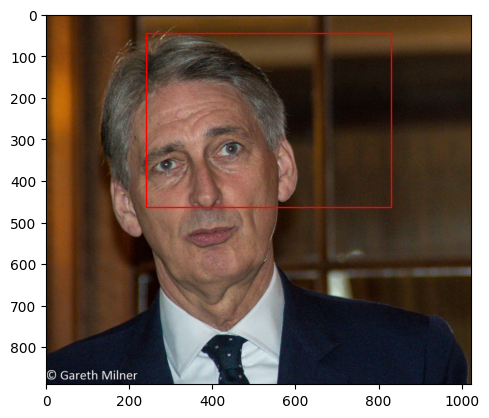

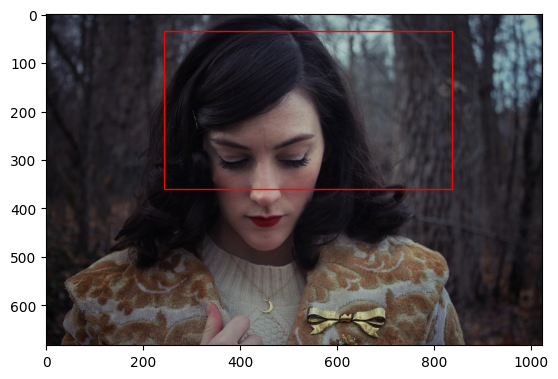

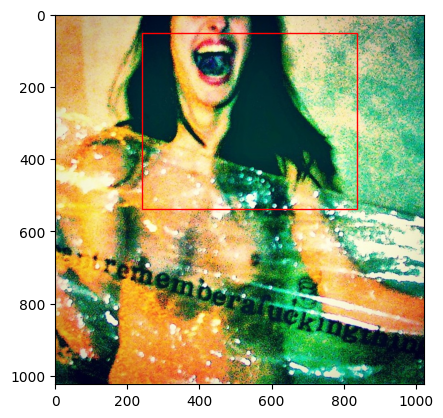

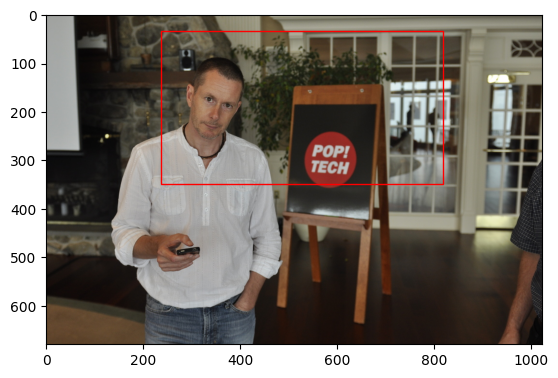

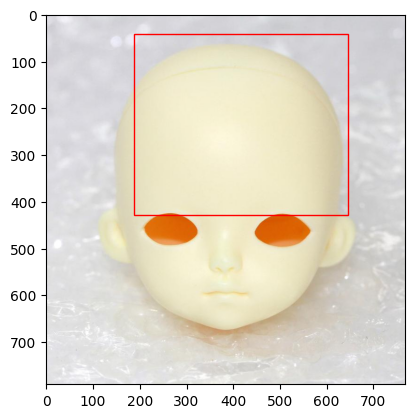

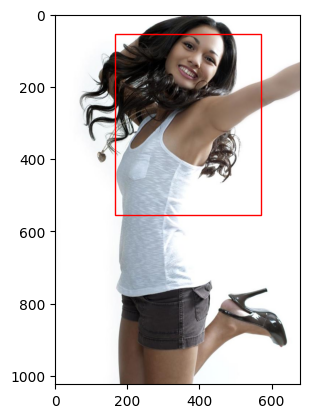

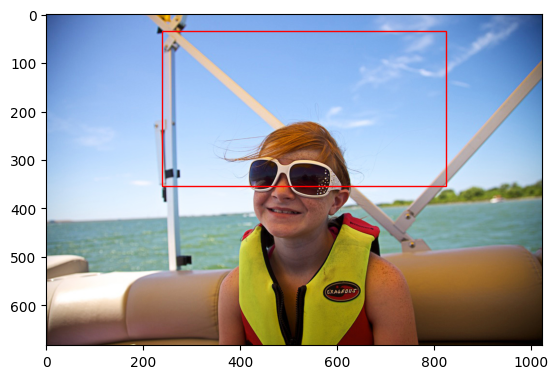

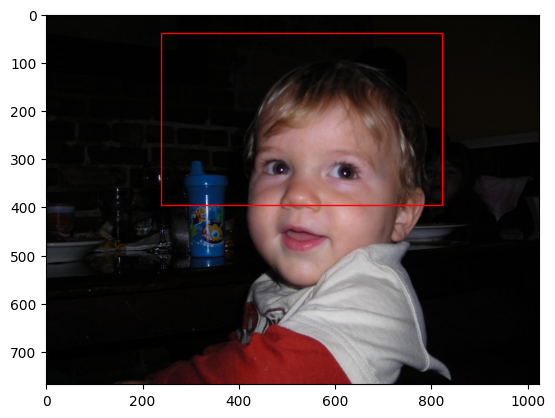

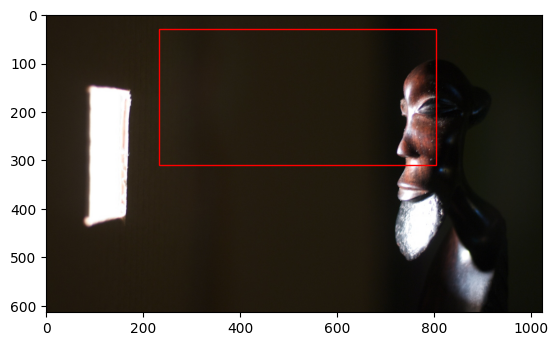

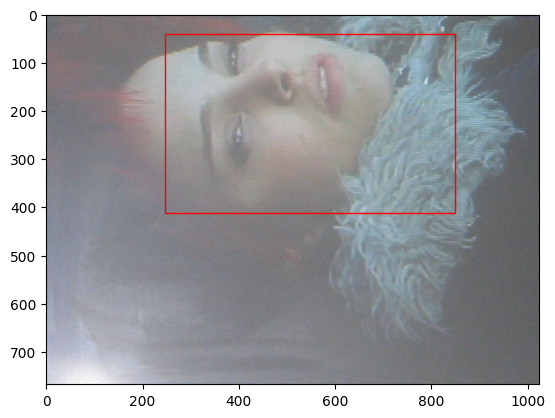

In [19]:
# evaluate - submission

from matplotlib import pyplot as plt
from matplotlib import patches

# test dataloader
testset_file_path = '/kaggle/input/testset/testset'
test_dataloader = get_test_dataloader(testset_file_path)

# model inference
#inf_model = MyFaceDetector().to(device)
#inf_model.load_state_dict(torch.load('/kaggle/working/best_model.pth', weights_only=True))
predictions = inference(model, test_dataloader, device)

# create submission
import csv
data = [['image_id', 'x1', 'y1', 'x2', 'y2']]

for i in range(len(predictions)):
    #print(predictions[i])
    img_id = predictions[i][0]['id'][0]
    image = cv2.imread(testset_file_path + '/' + img_id)
    #print(img_id)
    plabel = predictions[i][0]['labels'].item()
    #print(plabel)
    pbbox = predictions[i][0]['boxes'].cpu().tolist()[0][0]
    #print(pbbox)

    # scale predictions
    #h, w, _ = image.shape
    h, w = (244, 244)
    #print('scale height and width up to', h, w)
    #target_h, target_w = (224, 224)
    target_h, target_w, _ = image.shape
    #print(target_h, target_w)
    scale_x = target_w / w
    scale_y = target_h / h
    #scale_x = w / target_w
    #scale_y = h / target_h
    #print(scale_x, scale_y)
    x_min = int(pbbox[0] * scale_x)
    y_min = int(pbbox[1] * scale_y)
    x_max = int(pbbox[2] * scale_x)
    y_max = int(pbbox[3] * scale_y)
    pbbox = [x_min, y_min, x_max, y_max]

    # DEBUG: print bounding boxes on images
    #"""
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # plot bbox
    fig, ax = plt.subplots()
    #plt.figure()
    #coord = ((pbbox[0], pbbox[2], pbbox[2], pbbox[0], pbbox[0])
    #         (pbbox[1], pbbox[1], pbbox[3], pbbox[3], pbbox[1]))
    #plt.plot(*coord, c='r')
    ax.imshow(image_rgb)
    #plt.axis('off')  # Hide axes
    #bbox = patches.Rectangle(int(pbbox[0]), int(pbbox[1]), int(pbbox[2]), int(pbbox[3]), linewidth=1, edgecolor='r', facecolor='none')
    bbox = patches.Rectangle((pbbox[0], pbbox[1]), pbbox[2], pbbox[3], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(bbox)
    plt.show()
    #"""
    data.append([img_id, pbbox[0], pbbox[1], pbbox[2], pbbox[3]])
with open('od_out.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(data)

# This is for the next part of the assignment

# Exporting to ONNX

In [ ]:
#!pip install onnx
#!pip install onnxscript

In [ ]:
"""
# Model class must be defined somewhere
PATH = '/kaggle/working/best_model.pth'
model = MobileNetV2FaceDetector().to(device)
model.load_state_dict(torch.load(PATH))
model.eval()
dummy_input = torch.randn(1, 3, 224, 224).to(device)  # Adjust shape based on your model's input size

# Export the model to ONNX
torch.onnx.export(
    model,  # The loaded PyTorch model
    dummy_input,  # Example input tensor
    "model.onnx",  # Output ONNX file name
    export_params=True,  # Store trained parameters
    opset_version=13,  # ONNX version (adjust as needed)
    do_constant_folding=True,  # Optimize by folding constants
    input_names=["input"],  # Naming input tensor
    output_names=["output"],  # Naming output tensor
    dynamic_axes=None 
)

print("Model successfully exported to ONNX!")
"""